### 0.导入函数库

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import read
from obspy import read_inventory
from obspy.core import UTCDateTime
from obspy.signal.invsim import corn_freq_2_paz
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 10, 5

### 1.计算和绘制仪器响应

(1)使用plot_response()方法绘制仪器响应。min_freq参数确定了绘制的最低频率，最大绘制的频率总是Nyquist频率。<br>
```
图不仅显示了仪器的响应，还显示了从观测到实际存储数据的整个记录链路的响应。这包括实际地震仪的模拟响应、模数转换器 (DAC) 的模拟响应以及可能的数字滤波阶段。
该通道的采样率为每秒1个样本 (ΔT=1s)，因此奈奎斯特频率定义为：

fNyq=1/(2Δt),

即 fNyq=0.5 Hz。图中不显示高于奈奎斯特频率 (垂直虚线) 的频率，因为这些频率在数据中不存在，因此没有物理意义。
```

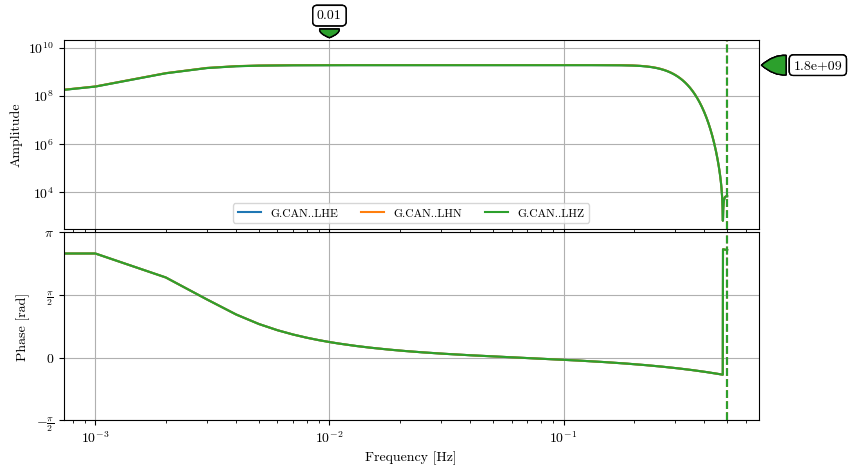

In [2]:
inv = read_inventory("../data/G.CAN.xml")
fig = inv.plot_response(min_freq=0.001)

(2)仪器的输入单位通常是地面运动的物理量，例如位移、速度或加速度。输出单位是仪器测量信号的物理量，例如电压或数字计数。
这意味着仪器将地面运动转换为测量信号，以便进行进一步分析和研究。通过测量信号，可以获取地震事件的相关信息，例如地震波的振幅、频率和相位。

In [3]:
inv[0][0][0].response

Channel Response
	From m/s (VELOCITY in Meters Per Second) to counts (DIGITAL UNIT in Counts)
	Overall Sensitivity: 1.85631e+09 defined at 0.010 Hz
	5 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 2266
		Stage 2: PolesZerosResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to counts, gain: 819200
		Stage 4: CoefficientsTypeResponseStage from counts to counts, gain: 1
		Stage 5: CoefficientsTypeResponseStage from counts to counts, gain: 1

(3)仪器响应描述了输入数据（无论仪器测量的是什么）如何转换为最终存储在文件中的形式。恢复原始地面运动需要对该过程进行反演。将仪器响应去除的过程称为反卷积，可以将数据转换回其原始单位。
如果分析需要其他单位，最好在仪器反卷积过程中进行积分或微分操作。
下面的演示了位移、速度和加速度的仪器响应 Id(ω), Iv(ω), Ia(ω)。
```
在这里，假设仪器响应是相对于加速度进行描述的。但是也可以考虑相对于速度或位移进行描述的仪器响应；关键是地震计的输出 C(ω) 是固定的。可以将输入的地面运动描述为位移、速度或加速度。在同时显示这三个变量并忽略显式的 ω 依赖性的情况。

实际上，在频率-振幅谱的对数坐标空间中，从 Xd(ω) 到 Xv(ω) 的变换会导致斜率增加一个单位。从 Id(ω) 到 Iv(ω) 的变换会导致斜率减小一个单位。

图中看到速度校正谱中的平坦段，位移显示相应的斜率增加，而加速度显示斜率减小。
```

Displacement


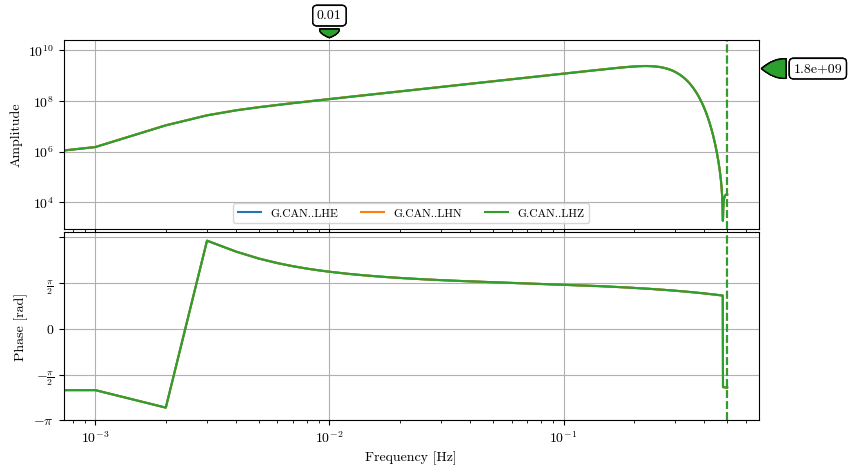

Velocity


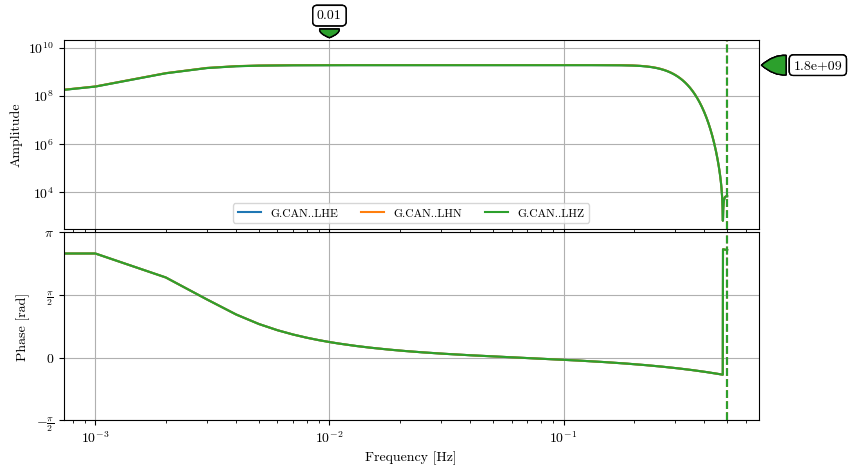

Acceleration


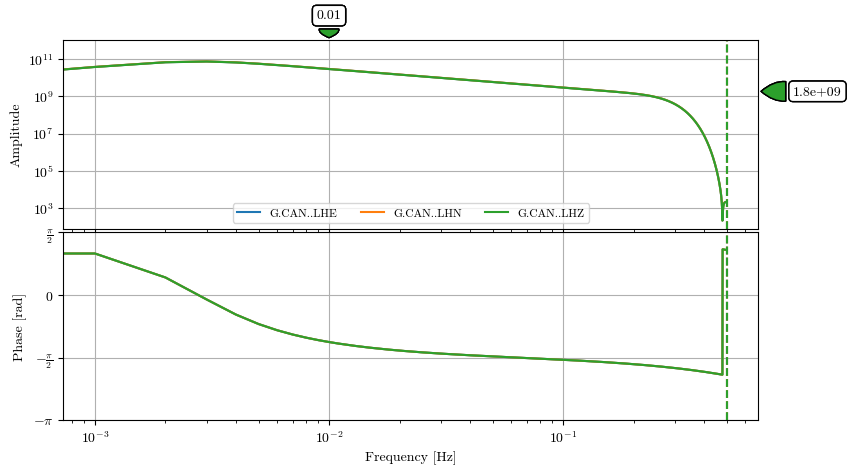

In [4]:
print("Displacement")
fig_dis = inv.plot_response(0.001, output="DISP")
print("Velocity")
fig_vel = inv.plot_response(0.001, output="VEL")
print("Acceleration")
fig_acc = inv.plot_response(0.001, output="ACC");

(4)显示在50-500秒带通滤波条件下，有无去仪器响应的波形。

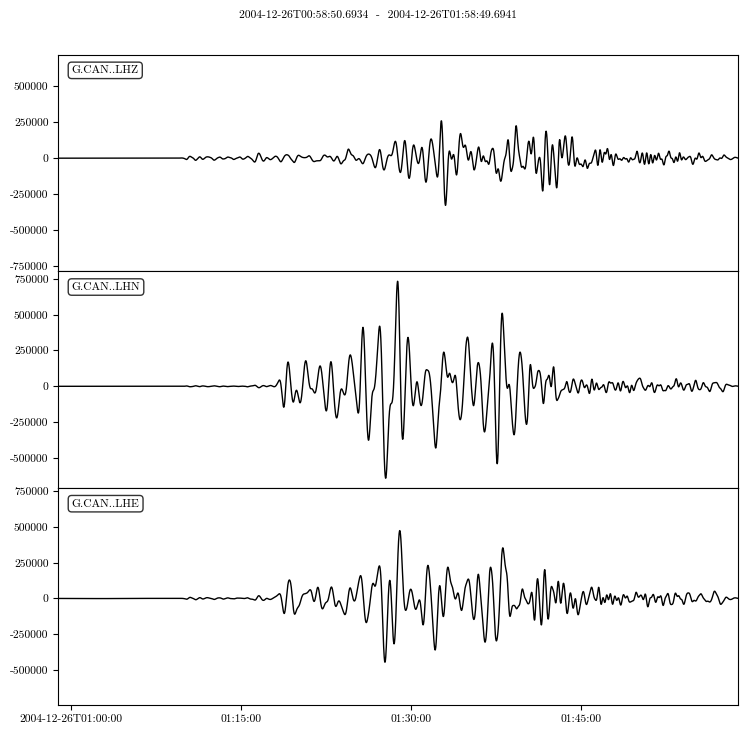

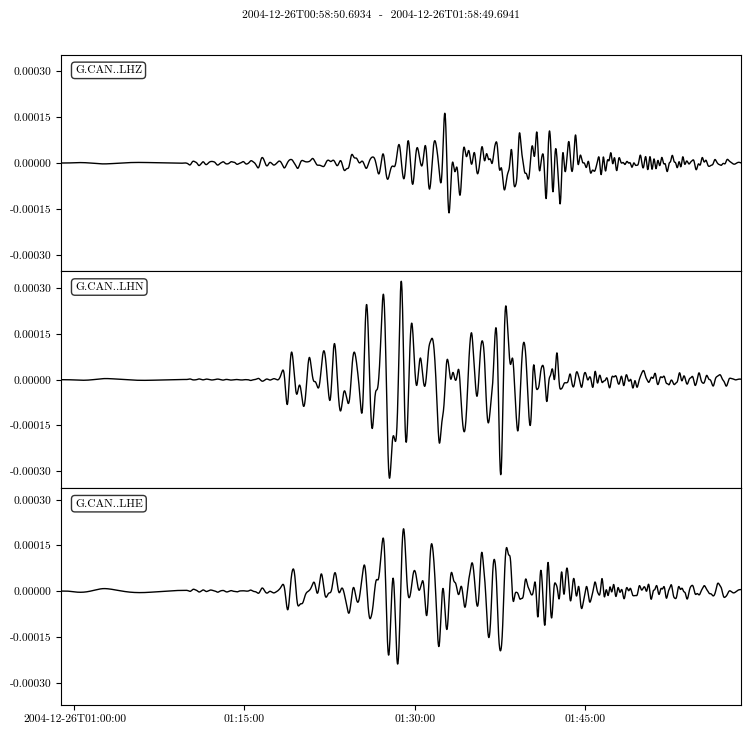

In [5]:
otime = UTCDateTime(2004, 12, 26, 0, 58, 50)
st = read("../data/CAN.mseed")
fig = st.slice(endtime=otime + 3600).copy().taper(0.05).filter(
    "bandpass", freqmin=1.0 / 500.0, freqmax=1.0 / 50.0).plot()

fig = st.slice(endtime=otime + 3600).copy().remove_response(
    inventory=inv, output="VEL").taper(0.05).filter(
    "bandpass", freqmin=1.0 / 500.0, freqmax=1.0 / 50.0).plot()

### 2.绘制频率范围内振幅谱

(1)无仪器矫正

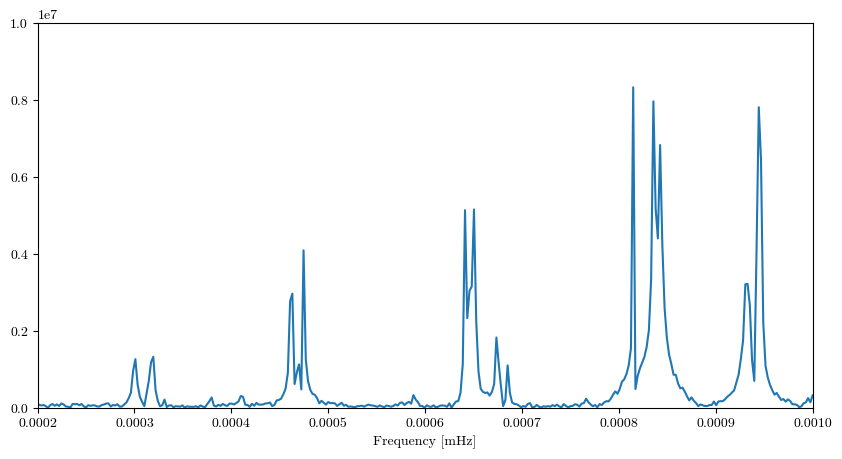

In [6]:
tr = st.select(component="Z")[0].copy().taper(0.05)
#对于纯实值输入的DFT（离散傅里叶变换），负频率是对应正频率的复共轭，是多余的
D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

# 绘图
plt.plot(freqs, np.abs(D))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0, 1E7)
plt.xlabel("Frequency [mHz]")
plt.show()

(2)去除仪器响应

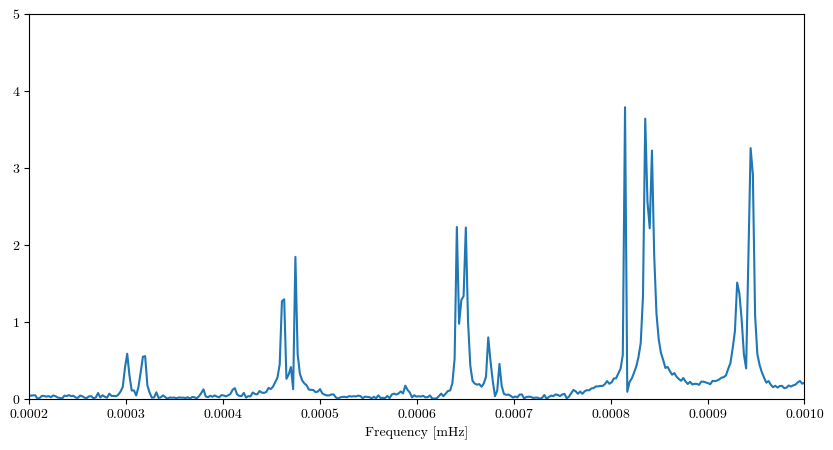

In [7]:
# output="DISP"|"ACC"|"VEL"
tr = st.select(component="Z").copy().remove_response(inventory=inv, 
                                                     output="DISP")[0]

D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

plt.plot(freqs, np.abs(D))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0, 5.0)
plt.xlabel("Frequency [mHz]")
plt.show()

### 3.波形仿真
```
1个零点：加速度计，2个零点：速度计， 3个零点：位移计
```

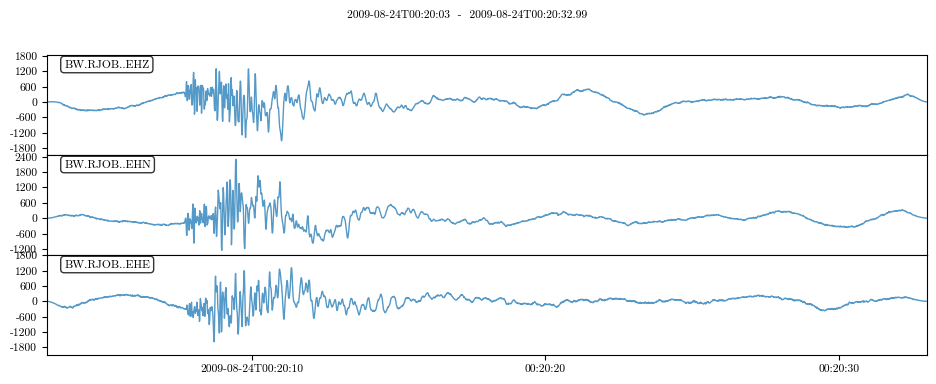

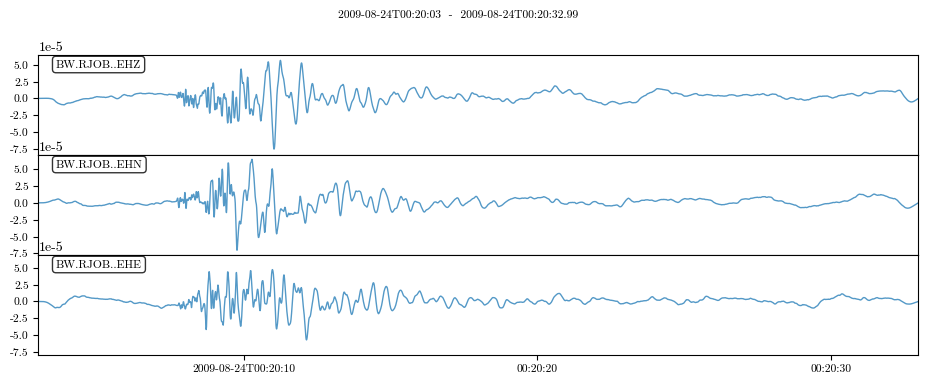

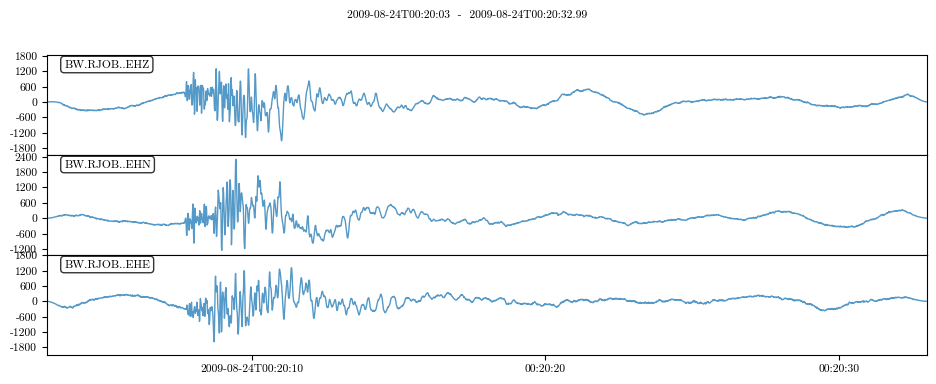

In [8]:
st = read("../data/BW.RJOB.mseed")

# sts2仪器响应
paz_sts2 = {'zeros': [0j, 0j],
            'poles': [-0.037004+0.037016j, -0.037004-0.037016j,
                      -251.33+0j,
                      -131.04-467.29j, -131.04+467.29j],
            'gain': 60077000.0,
            'sensitivity': 2516778400.0}

# 伍德安德森仪器响应
paz_wa = {'zeros': [0j],
          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j],
          'gain': 1,
          'sensitivity': 2800}

# sts2仿真成伍德安德森
st_sim = st.copy()
st_sim.simulate(paz_remove=paz_sts2, paz_simulate=paz_wa)

# 拐点频率1Hz，阻尼0.707计算仪器响应
paz_1hz = corn_freq_2_paz(1.0, damp=0.707)
paz_1hz['sensitivity'] = 1.0
st_cor = st.copy()
st_cor.copy().simulate(paz_remove=paz_sts2, paz_simulate=paz_1hz)

# 绘图
_ = st.plot(method="full", color="#5499C7", size=(1000,400), label="Original Data")
_ = st_sim.plot(method="full", color="#5499C7", size=(1000,400), label="Simulate Data")
_ = st.plot(method="full", color="#5499C7", size=(1000,400), label="Convert Data")